In [5]:
import pandas as pd
import csv 
import geopandas as gpd
from datetime import timedelta
from shapely.geometry import Point
import glob
from shapely import wkt

In [6]:
#read csv files and adjust to datetime

#imagery dates
R_im_date = pd.read_csv('../data/Ramsey/RamseyImageryDates.csv', parse_dates=['date'])
R_im_date['date'] = pd.to_datetime(R_im_date['date'])

#survey dates
R_sur_date = pd.read_csv('../data/Ramsey/RamseySurveyDates.csv', delimiter=';', index_col=False, parse_dates = ['Ramsey wet/dry date']) 
R_sur_date.rename(columns={'Ramsey wet/dry date':'date'}, inplace=True )
R_sur_date['date'] = pd.to_datetime(R_sur_date['date'], format = '%m/%d/%Y', errors = 'coerce')
R_sur_date = R_sur_date.dropna(subset = ['date'])

#hydrological data (precipitation and streamflow)
R_hyd = pd.read_csv('../data/Ramsey/RamseyHydroData.csv')
R_hyd.rename( columns={'Unnamed: 0':'date'}, inplace=True )
R_hyd['date'] = pd.to_datetime(R_hyd['date'])

#new precipitation file used later
R_precipitation = pd.read_csv('../data/Ramsey/daymet_precip.csv')
R_precipitation['system:time_start'] = pd.to_datetime(R_precipitation['system:time_start'])
R_precipitation.rename( columns={'00000000000000000000':'P','system:time_start':'day'}, inplace=True )

#surveydata with geometries having a wet/dry label, dates are only given in year
R_surveyData = pd.read_csv('../data/Ramsey/Ramsey_surveyData.csv')



In [7]:
#find matching dates between survey and imagery
matching_dates = []
tolerance = timedelta(days = 5)

for date1 in R_sur_date['date']:
    exact_date = False
    tol = False 
    for date2 in R_im_date['date']:
        if date1 == date2:
            matching_dates.append({'Survey': date1, 'Imagery': date2})
            exact_date = True
    if not exact_date:
        for date2 in R_im_date['date']:
            if abs(date1 - date2) <= tolerance:
                matching_dates.append({'Survey': date1, 'Imagery': date2})
                tol = True
        if not tol: 
            for date2 in R_im_date['date']:
                if abs(date1-date2) < timedelta(days = 10): 
                    matching_dates.append({'Survey': date1, 'Imagery': date2})


matching_df = pd.DataFrame(matching_dates)


In [8]:
R_datessurData = pd.merge(matching_df, R_hyd, left_on = 'Survey', right_on = 'date', how = 'left')
R_datesimData = pd.merge(matching_df, R_hyd, left_on = 'Imagery', right_on = 'date')
#R_datessurData = R_datessurData.drop(columns = ['Imagery','date'])
#R_datesimData = R_datesimData.drop(columns = ['Survey','date'])


In [9]:
#sum precipitation for dates in between survey and imagery
def sum_pdatesbetween(d1, d2):
    r = pd.date_range(start=min(d1,d2), end=max(d1,d2))
    return R_hyd[R_hyd['date'].isin(r)]['P [mm]'].sum()

In [10]:
#making a dataframe to determine which imagery dates to use
Rh = pd.DataFrame([])

Rh['Survey'] = matching_df['Survey']
Rh['Imagery'] = matching_df['Imagery']
Rh['sum_P'] = [sum_pdatesbetween(R_datessurData.loc[i, 'Survey'], R_datesimData.loc[i, 'Imagery']) for i in range(len(Rh))]
Rh['Q_s-i'] = (R_datessurData['Q [mm/d]'] - R_datesimData['Q [mm/d]']) / R_datessurData['Q [mm/d]'] * 100
Rh['Use/not'] = ['use', 'use', 'use', 'use', 'not', 'not',
                 'not', 'use', 'not', 'use'] 

Rh = Rh.fillna('')

conditions = (Rh['Use/not'] == 'not')

Rh = Rh[~conditions]

Rh = Rh.drop(columns=['Use/not'])

Rh

,Survey,Imagery,sum_P,Q_s-i
0,2018-06-23,2018-06-23,0.000000,
1,2019-06-15,2019-06-15,0.000000,0.0
2,2020-06-15,2020-06-15,0.931333,0.0
3,2021-06-16,2021-06-16,0.000000,
7,2022-06-12,2022-06-13,0.000000,
9,2023-06-13,2023-06-13,0.000000,0.0


In [11]:
Rh.to_csv('../data/Ramsey/Ramsey_survey_imagery_hydro.csv', index = 'False')

In [12]:
#First adjusting the dates in surveyData, as they are only logged with the respective year and not exact date
R_sur_date['Year'] = R_sur_date['date'].dt.year
R_surveyData['Year'] = R_surveyData['Year'].astype(int)
Rdata = pd.merge(R_surveyData, R_sur_date[['date', 'Year']], on = 'Year', how = 'left')
Rdata = Rdata.drop(columns=['Year', 'Unnamed: 0'])
Rdata.rename(columns = {'date':'Year'}, inplace = True)
Rdata = Rdata.drop_duplicates()
Rdata

,geometry,wetdry,Year
0,POINT (565860.5239241327 3479495.202555806),dry,2020-06-15
1,POINT (565857.1538633622 3479491.508954528),dry,2020-06-15
2,POINT (565853.7838025916 3479487.81535325),dry,2020-06-15
3,POINT (565850.4137418212 3479484.121751971),dry,2020-06-15
4,POINT (565847.0436810507 3479480.428150693),dry,2020-06-15
...,...,...,...
13793,POINT (563918.7609584624 3476832.570563339),dry,2023-06-13
13794,POINT (563918.0300093086 3476837.516846118),dry,2023-06-13
13795,POINT (563917.2990601548 3476842.463128897),dry,2023-06-13
13796,POINT (563916.5681110012 3476847.409411677),dry,2023-06-13


In [13]:
#survey data with dates into a geodataframe and adding x and y from the geometry to 
#facilitate merge

Rdata['geometry'] = Rdata['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(Rdata, geometry = 'geometry')#, crs='EPSG:26912')

gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
gdf = gdf[['geometry', 'x', 'y', 'wetdry', 'Year']]
#gdf['Year'] = gdf['Year'].astype(int) 
#gdf['Year'] = pd.to_datetime(gdf['Year'])
gdf

,geometry,x,y,wetdry,Year
0,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,dry,2020-06-15
1,POINT (565857.154 3479491.509),565857.153863,3.479492e+06,dry,2020-06-15
2,POINT (565853.784 3479487.815),565853.783803,3.479488e+06,dry,2020-06-15
3,POINT (565850.414 3479484.122),565850.413742,3.479484e+06,dry,2020-06-15
4,POINT (565847.044 3479480.428),565847.043681,3.479480e+06,dry,2020-06-15
...,...,...,...,...,...
13793,POINT (563918.761 3476832.571),563918.760958,3.476833e+06,dry,2023-06-13
13794,POINT (563918.030 3476837.517),563918.030009,3.476838e+06,dry,2023-06-13
13795,POINT (563917.299 3476842.463),563917.299060,3.476842e+06,dry,2023-06-13
13796,POINT (563916.568 3476847.409),563916.568111,3.476847e+06,dry,2023-06-13


In [14]:
#Checking for perennial reaches by comparing surveys of each year

gdf = gdf.set_geometry('geometry')#, crs='EPSG:26912')
#gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
#gdf['geometry_wkt'] = gdf['geometry'].apply(lambda geom: geom.wkt)

perennial = pd.DataFrame(gdf.groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'wet'))).reset_index(drop=False)

# whichever number is reasonable based on data?
perennial = perennial[(perennial['wetdry'] == 6)]

#assume always wet
perennial = perennial.assign(wetdry = 'wet')
#perennial['geometry'] = perennial['geometry_wkt'].apply(wkt.loads)
#perennial = perennial.drop(columns=['geometry_wkt'])

#perennial['geometry'] = perennial['geometry'].apply(wkt.loads)
gdf_perennial = gpd.GeoDataFrame(perennial, geometry = 'geometry')#, crs='EPSG:26912')
gdf_perennial['x'] = gdf_perennial.geometry.x
gdf_perennial['y'] = gdf_perennial.geometry.y

#making the gdf matching the perennial reaches to the imagery dates available 
imagery_perennial = pd.concat([gdf_perennial.assign(imagery = date) for date in R_im_date['date']], ignore_index=True)
imagery_perennial = imagery_perennial[~imagery_perennial['imagery'].isin(Rh['Imagery'])]
imagery_perennial['assumption'] = len(imagery_perennial)*['assumed perennial']
imagery_perennial

,geometry,wetdry,x,y,imagery,assumption
0,POINT (563350.778 3476892.462),wet,563350.777523,3.476892e+06,2016-07-22,assumed perennial
1,POINT (563355.191 3476890.112),wet,563355.190922,3.476890e+06,2016-07-22,assumed perennial
2,POINT (563377.258 3476878.363),wet,563377.257917,3.476878e+06,2016-07-22,assumed perennial
3,POINT (563372.845 3476880.713),wet,563372.844518,3.476881e+06,2016-07-22,assumed perennial
4,POINT (563368.431 3476883.063),wet,563368.431119,3.476883e+06,2016-07-22,assumed perennial
...,...,...,...,...,...,...
8115,POINT (563377.258 3476878.363),wet,563377.257917,3.476878e+06,2024-03-28,assumed perennial
8116,POINT (563372.845 3476880.713),wet,563372.844518,3.476881e+06,2024-03-28,assumed perennial
8117,POINT (563368.431 3476883.063),wet,563368.431119,3.476883e+06,2024-03-28,assumed perennial
8118,POINT (563364.018 3476885.413),wet,563364.017720,3.476885e+06,2024-03-28,assumed perennial


<Axes: >

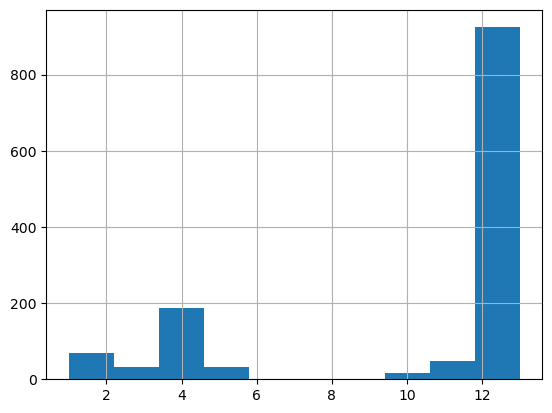

In [15]:
gdf.groupby('geometry').count().wetdry.hist()

In [16]:
# merging to be able to use the new precipitation data
R_new_hyd = R_hyd.merge( R_precipitation, left_on = 'date', right_on = 'day')
R_new_hyd = R_new_hyd.drop(columns = ['day', 'P [mm]'])
R_new_hyd.rename( columns={'P':'P [mm]'}, inplace=True )
R_new_hyd.set_index(['date'], drop =True, inplace = True)
R_new_hyd

,Q [mm/d],P [mm]
date,,
2016-01-01,0.000481,0.00
2016-01-02,0.000481,0.00
2016-01-03,0.000481,0.00
2016-01-04,0.000682,16.30
2016-01-05,0.000662,4.45
...,...,...
2023-12-27,0.000000,0.00
2023-12-28,0.000000,0.00
2023-12-29,0.000000,0.00


In [17]:
#function to define assumptions around dates to choose, based on streamflow and precipitation
def tolerance(Q_P_data, date, start, adjust, tolerance_p, P_condition = -999, Q_condition = -999):
    
    sub_grupp = Q_P_data.copy()
    
    if adjust == 'start':      
        sub_grupp = Q_P_data.loc[start:].copy()       
        
    elif adjust == 'end': #reverse index to loop backwards
        sub_grupp = sub_grupp.loc[:start].copy().iloc[::-1]        
    
    else:
        print('Invalid adjust parameter. Please use "start" or "end"')
        return

    
    # Reset index if reversed
    sub_grupp.reset_index(inplace=True)
     
    sub_grupp['Q_diff'] = sub_grupp['Q [mm/d]'].diff().fillna(0)

    if adjust == 'start':
        sub_grupp['tolerance_condition'] = (sub_grupp.Q_diff < tolerance_p * sub_grupp['Q [mm/d]'])

    if adjust == 'end':
        sub_grupp['tolerance_condition'] = (sub_grupp.Q_diff > -tolerance_p * sub_grupp['Q [mm/d]'])
    
    if P_condition == -999 == Q_condition:
        print('not a valid condition')
        return 
        
    elif P_condition == -999:
        if Q_condition > 0:
            sub_grupp['condition'] = sub_grupp['Q [mm/d]'] > Q_condition
        else:
            sub_grupp['condition'] = sub_grupp['Q [mm/d]'] < -Q_condition
            
    elif Q_condition == -999:
        if P_condition > 0:
            sub_grupp['condition'] = sub_grupp['P [mm]'] > P_condition
        else:
            sub_grupp['condition'] = sub_grupp['P [mm]'] < -P_condition
            
    else:
        if (Q_condition > 0) & (P_condition > 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] > Q_condition) & (sub_grupp['P [mm]'] > P_condition)
        elif (Q_condition < 0) & (P_condition > 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] < -Q_condition) & (sub_grupp['P [mm]'] > P_condition)           
        elif (Q_condition > 0) & (P_condition < 0):
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] > Q_condition) & (sub_grupp['P [mm]'] < -P_condition)            
        else:
            sub_grupp['condition'] = (sub_grupp['Q [mm/d]'] < -Q_condition) & (sub_grupp['P [mm]'] < -P_condition)

    #where conditions are met
    yesgroup = sub_grupp[(sub_grupp['condition'] == True) & (sub_grupp['tolerance_condition'] == True)] 
       
  
    if len(yesgroup) == 0:
        print('No data where conditions are met')
        return pd.DataFrame()
        
    #where conditions are not met
    nogroup = sub_grupp[(sub_grupp['condition'] == False) | (sub_grupp['tolerance_condition'] == False)]  
    
    if len(nogroup) == 0:
        print('nogroup = 0')
        return sub_grupp.loc[yesgroup.index[0]:]

    if yesgroup.index[0] < nogroup.index[0]:
        print('everything is fine')
        return sub_grupp.loc[:nogroup.index[0]]
    
    else:
        print('No valid range found between yesgroup and nogroup indices')
        return pd.DataFrame()




In [18]:
#assumption of dry dates after the survey date while in a recession 


dry_list = []

for date in Rdata['Year'].unique():
    dry1 = tolerance(R_new_hyd, 'date', date, 'start', 0.05, Q_condition = -999, P_condition = -1)
    if len(dry1) == 0:
        print('dry1 is empty')
        continue
    dry1 = dry1[~dry1['date'].isin(Rh['Imagery'])]
    dry_imagery = pd.merge(dry1, R_im_date, on = ['date'], how = 'inner')
    #print(len(dry_imagery))
    dry_points = pd.DataFrame(gdf[gdf['Year']== (date)] .groupby('geometry')['wetdry'].apply(lambda x: (x == 'dry'))).reset_index(drop = False)
    dry_points = dry_points.assign(wetdry = 'dry')
    dry_im_points = [dry_points.assign(imagery = date) for date in dry_imagery['date']]
    #print(len(dry_im_points))
    
    try:
        dry = pd.concat(dry_im_points).drop(columns = ['level_1'])
        dry_list.append(dry)
    except:
        if len(dry_im_points)==0:
            print('No data for date '+ date.strftime('%Y-%m-%d'))
        else:
            dry = dry_im_points[0]
            dry_list.append(dry)
    #print(len(dry))
    

dry_df = pd.concat(dry_list)
dry_df['assumption'] = len(dry_df)*['assumed dry']




No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2016-06-21
everything is fine
No data for date 2014-06-19
everything is fine
No data for date 2009-06-15
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2012-06-13
everything is fine
No data for date 2015-06-15
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2013-06-11
No valid range found between yesgroup and nogroup indices
dry1 is empty
everything is fine
No data for date 2010-06-10
everything is fine
everything is fine


In [19]:
#assuming wet stretches for the dates before
#assumption is made with 5 % difference in streamflow and for dates before survey when in a recession 

wet_list = []

for date in Rdata['Year'].unique():
            
    wet1 = tolerance(R_new_hyd, 'date', date, 'end', 0.05, Q_condition = -999, P_condition = -1)
    if len(wet1) == 0:
        print('wet1 is empty')
        continue
    wet1 = wet1[~wet1['date'].isin(Rh['Imagery'])]
    wet_imagery = pd.merge(wet1, R_im_date, on = ['date'], how = 'inner')
    #print(len(wet_imagery))
    wet_points = pd.DataFrame(gdf[gdf['Year']== (date)].groupby('geometry')['wetdry'].apply(lambda x: sum(x == 'wet'))).reset_index(drop = False)
    wet_points = wet_points[(wet_points['wetdry'] == 1)]
    wet_points = wet_points.assign(wetdry = 'wet')
    wet_im_points = [wet_points.assign(imagery = date) for date in wet_imagery['date']]
        
    try:
        wet = pd.concat(wet_im_points).drop(columns = ['level_1'])
        wet_list.append(wet)
    except:
        if len(wet_im_points)==0:
            print('No data for date '+ date.strftime('%Y-%m-%d'))
        else:
            wet = wet_im_points[0]
            wet_list.append(wet)
        

wet_df = pd.concat(wet_list)


wet_df['assumption'] = len(wet_df)*['assumed wet']

No valid range found between yesgroup and nogroup indices
wet1 is empty
everything is fine
No data for date 2016-06-21
No data where conditions are met
wet1 is empty
No data where conditions are met
wet1 is empty
No valid range found between yesgroup and nogroup indices
wet1 is empty
No data where conditions are met
wet1 is empty
No data where conditions are met
wet1 is empty
No valid range found between yesgroup and nogroup indices
wet1 is empty
No data where conditions are met
wet1 is empty
No valid range found between yesgroup and nogroup indices
wet1 is empty
No data where conditions are met
wet1 is empty
everything is fine
everything is fine


In [20]:
#matching gdf with the imagery dates
gdf['assumption'] = len(gdf)*['survey/imagery match']
gdf_imagery = pd.merge(gdf, Rh, left_on = 'Year', right_on = 'Survey', how = 'left')
gdf_imagery = gdf_imagery.drop(columns=['Survey', 'sum_P', 'Q_s-i', 'Year'])
# merging all data, both survey and expanded data for wetdry assumption
all_expanded = pd.concat([gdf_imagery, imagery_perennial, dry_df, wet_df])
all_expanded = gpd.GeoDataFrame(all_expanded, geometry = 'geometry')#, crs='EPSG:26912')
all_expanded['x'] = all_expanded.geometry.x
all_expanded['y'] = all_expanded.geometry.y
all_expanded = all_expanded.rename(columns = {'imagery':'date_first'})
all_expanded['date'] = all_expanded['Imagery'].combine_first(all_expanded['date_first'])
all_expanded

,geometry,x,y,wetdry,assumption,Imagery,date_first,date
0,POINT (565860.524 3479495.203),565860.523924,3.479495e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
1,POINT (565857.154 3479491.509),565857.153863,3.479492e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
2,POINT (565853.784 3479487.815),565853.783803,3.479488e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
3,POINT (565850.414 3479484.122),565850.413742,3.479484e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
4,POINT (565847.044 3479480.428),565847.043681,3.479480e+06,dry,survey/imagery match,2020-06-15,NaT,2020-06-15
...,...,...,...,...,...,...,...,...
269,POINT (564078.518 3476958.510),564078.518265,3.476959e+06,wet,assumed wet,NaT,2019-06-11,2019-06-11
99,POINT (563198.291 3477110.276),563198.291275,3.477110e+06,wet,assumed wet,NaT,2023-06-08,2023-06-08
100,POINT (563197.281 3477115.172),563197.280598,3.477115e+06,wet,assumed wet,NaT,2023-06-08,2023-06-08
107,POINT (563199.302 3477105.379),563199.301952,3.477105e+06,wet,assumed wet,NaT,2023-06-08,2023-06-08


In [21]:
#reading and concatenating the processed imagery 
path = '../data/Ramsey/processed_imagery'

processed_imagery = glob.glob(path + '/*.csv')
processed_imagery.sort(key = lambda x: int(x.split('_buffer_')[1].split('.')[0]))

con_ready_imagery = []
for processed in processed_imagery:
    df= pd.read_csv(processed)
    con_ready_imagery.append(df)

concatenated = pd.concat(con_ready_imagery)

In [22]:
#turning the processed imagery into a gdf with x and y columns 
concatenated['geometry'] = concatenated['geometry'].apply(wkt.loads)
gdf_processed = gpd.GeoDataFrame(concatenated, geometry = 'geometry')#, crs='EPSG:26912')
gdf_processed['date'] = pd.to_datetime(gdf_processed['date'], format='%Y%m%d')
gdf_processed['x'] = gdf_processed.geometry.x
gdf_processed['y'] = gdf_processed.geometry.y
gdf_processed = gdf_processed.drop_duplicates()
gdf_processed

,blue,green,red,NIR,missing,NDWI,p,date,geometry,x,y
0,118.67,488.22,586.67,2784.22,0,-0.70,0,2023-11-06,POINT (566246.049 3479852.011),566246.049067,3.479852e+06
2,111.44,475.89,548.22,2778.33,0,-0.71,0,2023-11-06,POINT (566241.855 3479849.289),566241.854584,3.479849e+06
3,71.56,409.11,414.11,2665.22,0,-0.73,0,2023-11-06,POINT (566237.660 3479846.568),566237.660101,3.479847e+06
4,53.89,383.56,378.11,2560.78,0,-0.74,0,2023-11-06,POINT (566233.466 3479843.847),566233.465618,3.479844e+06
5,58.56,391.44,398.44,2605.33,0,-0.74,0,2023-11-06,POINT (566229.271 3479841.125),566229.271135,3.479841e+06
...,...,...,...,...,...,...,...,...,...,...,...
190605,0.00,0.00,0.00,0.00,0,NaN,0,2018-05-03,POINT (563919.024 3476832.283),563919.024456,3.476832e+06
190606,0.00,0.00,0.00,0.00,0,NaN,0,2018-05-03,POINT (563918.293 3476837.229),563918.293496,3.476837e+06
190607,0.00,0.00,0.00,0.00,0,NaN,0,2018-05-03,POINT (563917.563 3476842.175),563917.562535,3.476842e+06
190608,0.00,0.00,0.00,0.00,0,NaN,0,2018-05-03,POINT (563916.832 3476847.122),563916.831574,3.476847e+06


In [23]:
precision = 5
all_expanded['x'] = all_expanded['x'].round(precision)
all_expanded['y'] = all_expanded['y'].round(precision)
gdf_processed['x'] = gdf_processed['x'].round(precision)
gdf_processed['y'] = gdf_processed['y'].round(precision)

In [24]:
merged = all_expanded.merge(gdf_processed, on=['date', 'x', 'y'])
#merge isn't working so performing a nearest spatial joing
if len(merged) == 0:
    print("Merge returned empty. Doing a spatial join based on proximity.")
    # using the smallest distance that worked
    result = gpd.sjoin_nearest(all_expanded, gdf_processed, how='inner', max_distance=0.4) 
    # filtering so all dates also match from the two gdfs
    result = result[result['date_left'] == result['date_right']]
    result = result.drop(columns = ['geometry', 'x_right', 'y_right', 'date_right', 'index_right', 'Imagery', 'date_first'])

Merge returned empty. Doing a spatial join based on proximity.


In [25]:
result = result.rename(columns = {'x_left':'x', 'y_left':'y', 'date_left':'date'})
result_sorted = result.sort_values(by='date')
result_sorted = result_sorted.drop_duplicates()
result_sorted.dropna(inplace = True)
result_sorted

,x,y,wetdry,assumption,date,blue,green,red,NIR,missing,NDWI,p
0,563350.77752,3.476892e+06,wet,assumed perennial,2016-07-22,206.44,461.22,587.78,2945.67,0,-0.73,0
1,563355.19092,3.476890e+06,wet,assumed perennial,2016-07-22,176.78,432.67,564.89,2828.56,0,-0.73,0
2,563377.25792,3.476878e+06,wet,assumed perennial,2016-07-22,232.11,474.44,606.33,2779.78,0,-0.71,0
3,563372.84452,3.476881e+06,wet,assumed perennial,2016-07-22,223.89,462.11,592.78,2686.78,0,-0.71,0
4,563368.43112,3.476883e+06,wet,assumed perennial,2016-07-22,143.67,372.33,505.89,2596.11,0,-0.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8113,563350.77752,3.476892e+06,wet,assumed perennial,2024-03-28,105.33,375.78,427.33,1856.44,0,-0.66,0
8113,563350.77752,3.476892e+06,wet,assumed perennial,2024-03-28,239.11,433.89,493.33,1953.33,0,-0.64,0
8113,563350.77752,3.476892e+06,wet,assumed perennial,2024-03-28,109.89,374.33,422.11,1861.56,0,-0.67,0
8116,563372.84452,3.476881e+06,wet,assumed perennial,2024-03-28,262.11,512.22,568.78,2275.11,0,-0.63,0


In [26]:
result_sorted.to_csv('../data/Ramsey/processed_assumptions/processed_with_dates_and_assumptions_new.csv', encoding='utf-8', index=False)

In [27]:
#in case geometry gets fixed and the file increases in size as a result 
#start = 0
#splitnum = ?
#for i in range(1,splitnum+1):
#    newstart = int(len(result_sorted)/splitnum*i)
#    result_sorted.iloc[start:newstart].to_csv('../data/Ramsey/processed_assumptions/processed_with_dates_and_assumptions'+str(i)+'.csv',index=False,
#                      float_format='%.2f')
#    start = newstart

